In [1]:
import Pkg
Pkg.activate(".")

  Activating project at `~/Bipropellant-Propulsion-System-Model/julia`


In [2]:
# Numerics
using DifferentialEquations, ModelingToolkit
# Display
using Plots

In [8]:
@parameters t
D = Differential(t)

(::Differential) (generic function with 3 methods)

In [18]:
R̄ = 8.314 # J/mol/K
# Flow connectors connect by making the sum zero
# Equality connectors connect by making the values equal #! This is the default behavior
# Stream connectors are for fluids
# https://discourse.julialang.org/t/modelingtoolkit-variable-metadata-for-connectors/92056/3
@connector FluidPort begin
    p(t) = 0.0
    T(t) = 0.0, [connect = Stream]
    ṁ(t) = 0.0, [connect = Flow]
end

@mtkmodel FluidElement begin
    @components begin
        port_a = FluidPort()
        port_b = FluidPort()
    end
    @variables begin
        dp(t) = 0.0 # Pa
        ṁ(t) = 0.0 # kg/s
    end
    @equations begin
        dp ~ port_a.p - port_b.p
        port_a.ṁ ~ ṁ
        port_a.ṁ + port_b.ṁ ~ 0
    end
end

@mtkmodel GasVolume begin
    @components begin
        port_a = FluidPort()
        port_b = FluidPort()
    end

    @parameters begin
        m_init = 1.0 # kg
        p_init = 1e5 # Pa
        T = 300.0 # K
        V = 1.0 # m^3
        molar_mass = 14e-3 # kg/mol
    end

    @variables begin
        m(t) = m_init
        p(t) = p_init
    end

    @equations begin
        # Mass balance
        D(m) ~ port_a.ṁ + port_b.ṁ
        p * V ~ m / molar_mass * R̄ * T

        # Connect to ports
        port_a.p ~ p
        port_a.T ~ T

        port_b.p ~ p
        port_b.T ~ T
    end
end

@mtkmodel LiquidVolume begin
    @components begin
        port_a = FluidPort()
        port_b = FluidPort()
    end

    @parameters begin
        m_init = 1.0 # kg
    end

    @variables begin
        m(t) = m_init
        p(t)
    end

    @equations begin
        D(m) ~ port_a.ṁ + port_b.ṁ

        port_a.p ~ p
        port_b.p ~ p
    end
end

@mtkmodel PressureInterface begin
    @extend ṁ, dp = element1d = FluidElement()
    @equations begin
        ṁ ~ 0
        dp ~ 0
    end
end

# TwoPhaseTank with a gas and liquid phase
# Pressure determined by the gas phase
@component function TwoPhaseVolume(; name, mass_L=1.0, mass_G=0.5, p_init=1e5)
    @named gas = GasVolume(m_init = mass_G, p_init = p_init)
    @named liquid = LiquidVolume(m_init = mass_L)
    @named interface = PressureInterface()

    sys = [
        gas,
        liquid,
        interface,
    ]
    eqs = [
        connect(gas.port_a, interface.port_a),
        connect(liquid.port_a, interface.port_b),
    ]
    ODESystem(eqs, t, [], []; name=name, systems=sys)
end

@mtkmodel FluidResistor begin
    @extend ṁ, dp = element1d = FluidElement()
    @parameters begin
        R = 1e-6 # 1 kg/s/MPa
    end
    @equations begin
        ṁ ~ dp * R
    end
end

@mtkmodel ThreeWayValve begin
    @components begin
        port_a = FluidPort()
        port_b = FluidPort()
        port_c = FluidPort()
    end
    @equations begin
        port_a.p ~ port_b.p
        port_a.p ~ port_c.p
        port_a.ṁ + port_b.ṁ + port_c.ṁ ~ 0
    end
end

@mtkmodel ConstPressure begin
    @components begin
        port = FluidPort()
    end
    @parameters begin
        p = 1e5 # Pa
    end
    @equations begin
        port.p ~ p
    end
end

ModelingToolkit.Model{typeof(__ConstPressure__), Dict{Symbol, Any}}(__ConstPressure__, Dict{Symbol, Any}(:components => [[:port, :FluidPort]], :kwargs => Dict{Symbol, Any}(:p => 100000.0), :independent_variable => t, :parameters => Dict{Symbol, Dict{Symbol, Any}}(:p => Dict(:default => 100000.0)), :equations => ["port.p ~ p"]), false)

In [21]:
@named N2_tank = GasVolume(p_init=70e5, m_init=10.0)
@named N2_orifice = FluidResistor(R=1e-6)
@named N2_valve = ThreeWayValve()

@named N2O_inlet = FluidResistor(R=1e-6)
@named N2O_tank = TwoPhaseVolume(mass_L=1.0, mass_G=0.5, p_init=1e5)
@named N2O_orifice = FluidResistor(R=1e-6)

@named MeOH_inlet = FluidResistor(R=1e-6)
@named MeOH_tank = TwoPhaseVolume(mass_L=1.5, mass_G=0.1, p_init=1e5)
@named MeOH_orifice = FluidResistor(R=1e-6)

@named feed_valve = ThreeWayValve()
@named engine = FluidResistor(R=1e-5)
@named atm = ConstPressure(p=1e5)

connections = [
    # N2
    connect(N2_tank.port_a, N2_orifice.port_a),
    connect(N2_orifice.port_b, N2_valve.port_a),
    # N2O
    connect(N2_valve.port_b, N2O_inlet.port_a),
    connect(N2O_inlet.port_b, N2O_tank.gas.port_a),
    connect(N2O_tank.liquid.port_b, N2O_orifice.port_a),
    # MeOH
    connect(N2_valve.port_c, MeOH_inlet.port_a),
    connect(MeOH_inlet.port_b, MeOH_tank.gas.port_a),
    connect(MeOH_tank.liquid.port_b, MeOH_orifice.port_a),
    # Engine
    connect(N2O_orifice.port_b, feed_valve.port_a),
    connect(MeOH_orifice.port_b, feed_valve.port_b),
    connect(feed_valve.port_c, engine.port_a),
    connect(engine.port_b, atm.port),
]

@named model = ODESystem(connections, t,
    systems=[
        N2_tank,
        N2_orifice,
        N2_valve,
        N2O_inlet,
        N2O_tank,
        N2O_orifice,
        MeOH_inlet,
        MeOH_tank,
        MeOH_orifice,
        feed_valve,
        engine,
        atm,
    ],
)
sys = structural_simplify(model)
prob = ODEProblem(
    sys,
    ModelingToolkit.missing_variable_defaults(sys),
    (0, 5.0),
)
# prob = ODEProblem(sys, tspan=(0.0, 5.0))
sol = solve(prob)

# plot(sol)

retcode: Success
Interpolation: specialized 4rd order "free" stiffness-aware interpolation
t: 11-element Vector{Float64}:
 0.0
 1.0e-6
 1.1e-5
 0.00011099999999999999
 0.0011109999999999998
 0.011110999999999996
 0.11111099999999996
 0.8598885097392373
 2.2134560045616474
 4.115519229220477
 5.0
u: 11-element Vector{Vector{Float64}}:
 [10.0, 0.5, 1.0, 0.1, 1.5, 0.611672857142857, -0.07758809523809523]
 [9.999998847917245, 0.5000005404099519, 1.0000000031625798, 0.10000061167280265, 1.5000000744254303, 0.6116727481689781, -0.07758792419495202]
 [9.999987327100989, 0.5000059445041752, 1.0000000347840199, 0.10000672839483565, 1.50000081867468, 0.6116716584312571, -0.07758621376519569]
 [9.999872120067304, 0.500059984916884, 1.0000003505629689, 0.10006789501581366, 1.5000082606618987, 0.6116607611608255, -0.0775691096352301]
 [9.998720162610656, 0.5006003360950024, 1.000003464810176, 0.10067950129434321, 1.5000826300095174, 0.6115517991336892, -0.07739808509425561]
 [9.987211868628767, 0.5

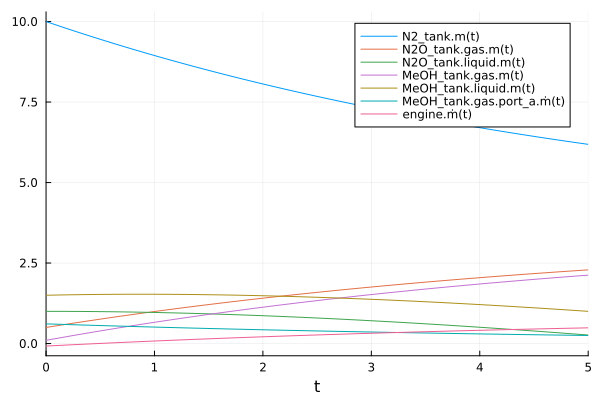

In [22]:
plot(sol)

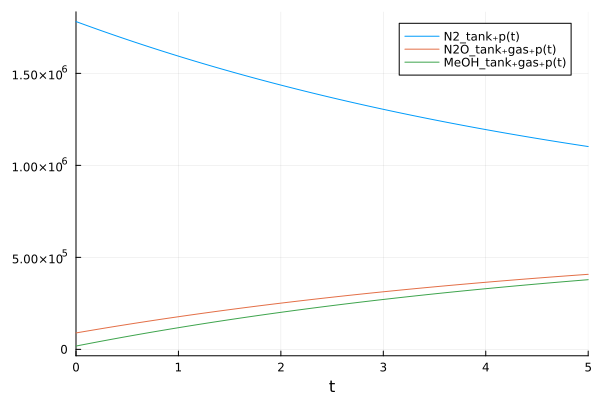

In [28]:
plot(sol, idxs = [N2_tank.p, N2O_tank.gas.p, MeOH_tank.gas.p])